# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:12<00:00, 5.00kFile/s]


Extracting celeba...


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

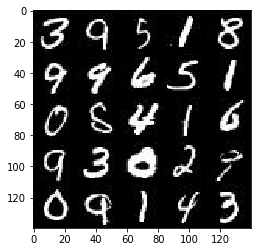

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

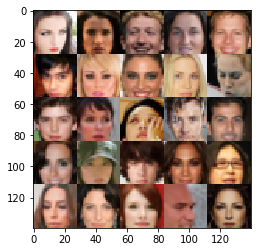

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, name="lr")

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.1
    keep_prob = 0.9

    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        flat = tf.reshape(x3, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.1
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # shape = 7x7x512
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        g2 = tf.nn.dropout(g2, keep_prob=keep_prob)
        # shape = 14x14x256
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        g3 = tf.nn.dropout(g3, keep_prob=keep_prob)
        # shape = 28x28x128
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 3, strides=1, padding='same', activation=None)
        # shape = 28x28x5
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_output = generator(input_z, out_channel_dim)
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(g_output, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_real,
            labels = tf.ones_like(disc_output_real) * (1 - smooth)
        )
    )
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.zeros_like(disc_output_fake)
        )
    )
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.ones_like(disc_output_fake)
        )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)

        return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)

    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))
                    
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

initial output:


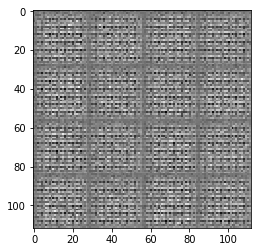

Epoch 1/2... Generator Loss: 2.1947 Discriminator Loss: 0.5528...
Epoch 1/2... Generator Loss: 4.0457 Discriminator Loss: 0.3983...
Epoch 1/2... Generator Loss: 3.8047 Discriminator Loss: 0.3848...
Epoch 1/2... Generator Loss: 1.3688 Discriminator Loss: 0.8422...
Epoch 1/2... Generator Loss: 1.3771 Discriminator Loss: 1.1536...
Epoch 1/2... Generator Loss: 1.5816 Discriminator Loss: 0.9685...
Epoch 1/2... Generator Loss: 0.9194 Discriminator Loss: 1.3459...
Epoch 1/2... Generator Loss: 1.3658 Discriminator Loss: 1.1077...
Epoch 1/2... Generator Loss: 1.6884 Discriminator Loss: 1.2670...
Epoch 1/2... Generator Loss: 1.2717 Discriminator Loss: 1.1438...


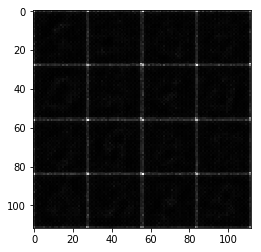

Epoch 1/2... Generator Loss: 1.1827 Discriminator Loss: 1.1762...
Epoch 1/2... Generator Loss: 1.5651 Discriminator Loss: 1.2362...
Epoch 1/2... Generator Loss: 1.4113 Discriminator Loss: 1.0752...
Epoch 1/2... Generator Loss: 1.5779 Discriminator Loss: 1.0610...
Epoch 1/2... Generator Loss: 0.8400 Discriminator Loss: 1.1389...
Epoch 1/2... Generator Loss: 0.8552 Discriminator Loss: 1.1489...
Epoch 1/2... Generator Loss: 0.8514 Discriminator Loss: 1.1282...
Epoch 1/2... Generator Loss: 1.7763 Discriminator Loss: 1.0958...
Epoch 1/2... Generator Loss: 1.1351 Discriminator Loss: 0.9552...
Epoch 1/2... Generator Loss: 2.1463 Discriminator Loss: 1.0419...


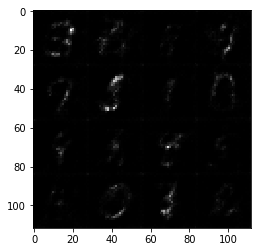

Epoch 1/2... Generator Loss: 1.3207 Discriminator Loss: 0.9563...
Epoch 1/2... Generator Loss: 1.1965 Discriminator Loss: 0.9401...
Epoch 1/2... Generator Loss: 1.3632 Discriminator Loss: 0.9354...
Epoch 1/2... Generator Loss: 1.8927 Discriminator Loss: 0.9463...
Epoch 1/2... Generator Loss: 1.5460 Discriminator Loss: 0.8984...
Epoch 1/2... Generator Loss: 1.0786 Discriminator Loss: 1.0087...
Epoch 1/2... Generator Loss: 0.5726 Discriminator Loss: 1.3916...
Epoch 1/2... Generator Loss: 1.3751 Discriminator Loss: 0.9841...
Epoch 1/2... Generator Loss: 2.0894 Discriminator Loss: 1.0574...
Epoch 1/2... Generator Loss: 0.9142 Discriminator Loss: 1.0631...


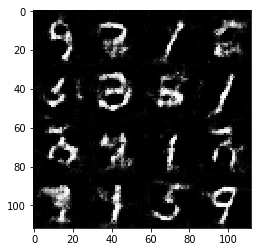

Epoch 1/2... Generator Loss: 1.5511 Discriminator Loss: 0.9806...
Epoch 1/2... Generator Loss: 0.9581 Discriminator Loss: 1.0898...
Epoch 1/2... Generator Loss: 1.2729 Discriminator Loss: 1.0762...
Epoch 1/2... Generator Loss: 1.1572 Discriminator Loss: 0.9774...
Epoch 1/2... Generator Loss: 1.0197 Discriminator Loss: 1.0494...
Epoch 1/2... Generator Loss: 0.9118 Discriminator Loss: 1.1293...
Epoch 1/2... Generator Loss: 0.7533 Discriminator Loss: 1.1865...
Epoch 1/2... Generator Loss: 0.5851 Discriminator Loss: 1.3411...
Epoch 1/2... Generator Loss: 0.7008 Discriminator Loss: 1.1948...
Epoch 1/2... Generator Loss: 1.3734 Discriminator Loss: 0.9700...


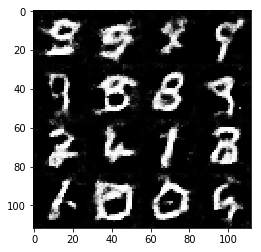

Epoch 1/2... Generator Loss: 1.1011 Discriminator Loss: 1.0033...
Epoch 1/2... Generator Loss: 1.7430 Discriminator Loss: 1.0546...
Epoch 1/2... Generator Loss: 1.2780 Discriminator Loss: 1.0171...
Epoch 1/2... Generator Loss: 1.2858 Discriminator Loss: 1.0553...
Epoch 1/2... Generator Loss: 0.6533 Discriminator Loss: 1.2706...
Epoch 1/2... Generator Loss: 0.9838 Discriminator Loss: 1.1461...
Epoch 2/2... Generator Loss: 0.4489 Discriminator Loss: 1.5890...
Epoch 2/2... Generator Loss: 1.5598 Discriminator Loss: 1.0802...
Epoch 2/2... Generator Loss: 1.2959 Discriminator Loss: 1.0247...
Epoch 2/2... Generator Loss: 1.4984 Discriminator Loss: 1.0851...


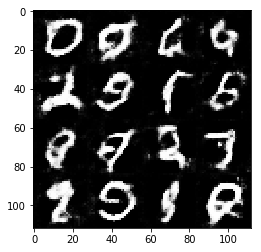

Epoch 2/2... Generator Loss: 0.4941 Discriminator Loss: 1.4882...
Epoch 2/2... Generator Loss: 1.0705 Discriminator Loss: 1.0367...
Epoch 2/2... Generator Loss: 0.9106 Discriminator Loss: 1.1986...
Epoch 2/2... Generator Loss: 1.1593 Discriminator Loss: 1.0098...
Epoch 2/2... Generator Loss: 0.7686 Discriminator Loss: 1.1264...
Epoch 2/2... Generator Loss: 0.9596 Discriminator Loss: 1.0670...
Epoch 2/2... Generator Loss: 1.0176 Discriminator Loss: 0.9892...
Epoch 2/2... Generator Loss: 1.3464 Discriminator Loss: 1.0174...
Epoch 2/2... Generator Loss: 1.1404 Discriminator Loss: 1.0464...
Epoch 2/2... Generator Loss: 0.9106 Discriminator Loss: 1.1192...


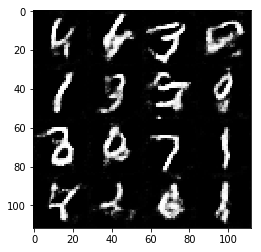

Epoch 2/2... Generator Loss: 1.6335 Discriminator Loss: 1.2338...
Epoch 2/2... Generator Loss: 1.0809 Discriminator Loss: 1.0338...
Epoch 2/2... Generator Loss: 1.0975 Discriminator Loss: 0.9998...
Epoch 2/2... Generator Loss: 1.2578 Discriminator Loss: 1.0320...
Epoch 2/2... Generator Loss: 0.9224 Discriminator Loss: 1.1270...
Epoch 2/2... Generator Loss: 0.9626 Discriminator Loss: 1.0460...
Epoch 2/2... Generator Loss: 2.1449 Discriminator Loss: 1.2610...
Epoch 2/2... Generator Loss: 1.2533 Discriminator Loss: 0.9858...
Epoch 2/2... Generator Loss: 0.7910 Discriminator Loss: 1.1288...
Epoch 2/2... Generator Loss: 1.2320 Discriminator Loss: 1.0636...


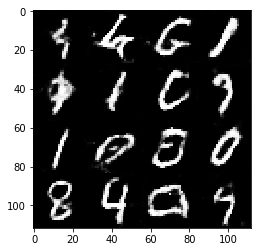

Epoch 2/2... Generator Loss: 1.5707 Discriminator Loss: 0.9920...
Epoch 2/2... Generator Loss: 1.1001 Discriminator Loss: 1.0435...
Epoch 2/2... Generator Loss: 1.4085 Discriminator Loss: 0.9791...
Epoch 2/2... Generator Loss: 1.0034 Discriminator Loss: 1.0759...
Epoch 2/2... Generator Loss: 1.0490 Discriminator Loss: 1.0025...
Epoch 2/2... Generator Loss: 1.9851 Discriminator Loss: 1.0904...
Epoch 2/2... Generator Loss: 0.9357 Discriminator Loss: 1.0548...
Epoch 2/2... Generator Loss: 0.9409 Discriminator Loss: 1.1336...
Epoch 2/2... Generator Loss: 1.2875 Discriminator Loss: 0.9687...
Epoch 2/2... Generator Loss: 0.5865 Discriminator Loss: 1.3734...


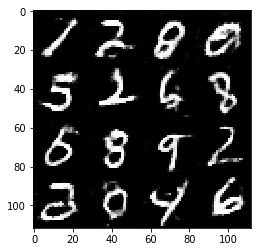

Epoch 2/2... Generator Loss: 1.0292 Discriminator Loss: 1.0844...
Epoch 2/2... Generator Loss: 1.2436 Discriminator Loss: 0.9741...
Epoch 2/2... Generator Loss: 1.2590 Discriminator Loss: 0.9847...
Epoch 2/2... Generator Loss: 1.5493 Discriminator Loss: 1.0484...
Epoch 2/2... Generator Loss: 0.8846 Discriminator Loss: 1.0490...
Epoch 2/2... Generator Loss: 1.0550 Discriminator Loss: 1.0068...
Epoch 2/2... Generator Loss: 1.2023 Discriminator Loss: 0.9629...
Epoch 2/2... Generator Loss: 1.2007 Discriminator Loss: 0.9266...
Epoch 2/2... Generator Loss: 1.7236 Discriminator Loss: 1.0313...
Epoch 2/2... Generator Loss: 1.0001 Discriminator Loss: 1.0317...


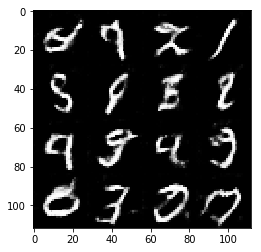

Epoch 2/2... Generator Loss: 0.8102 Discriminator Loss: 1.1535...
Epoch 2/2... Generator Loss: 1.4732 Discriminator Loss: 1.0585...
Epoch 2/2... Generator Loss: 2.0957 Discriminator Loss: 1.1113...


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

initial output:


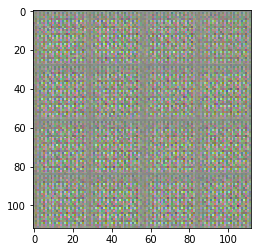

Epoch 1/1... Generator Loss: 4.3152 Discriminator Loss: 0.4444...
Epoch 1/1... Generator Loss: 2.6065 Discriminator Loss: 0.5079...
Epoch 1/1... Generator Loss: 2.3941 Discriminator Loss: 0.5546...
Epoch 1/1... Generator Loss: 4.2373 Discriminator Loss: 0.5904...
Epoch 1/1... Generator Loss: 0.6907 Discriminator Loss: 1.4159...
Epoch 1/1... Generator Loss: 5.0761 Discriminator Loss: 1.0807...
Epoch 1/1... Generator Loss: 2.0370 Discriminator Loss: 0.6939...
Epoch 1/1... Generator Loss: 0.8925 Discriminator Loss: 1.0544...
Epoch 1/1... Generator Loss: 2.5096 Discriminator Loss: 0.5631...
Epoch 1/1... Generator Loss: 2.3130 Discriminator Loss: 0.5259...


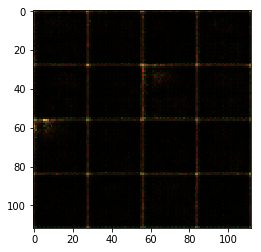

Epoch 1/1... Generator Loss: 3.8155 Discriminator Loss: 0.4275...
Epoch 1/1... Generator Loss: 2.1871 Discriminator Loss: 0.9079...
Epoch 1/1... Generator Loss: 0.5154 Discriminator Loss: 1.4604...
Epoch 1/1... Generator Loss: 1.3419 Discriminator Loss: 0.9670...
Epoch 1/1... Generator Loss: 2.3446 Discriminator Loss: 0.8599...
Epoch 1/1... Generator Loss: 0.3008 Discriminator Loss: 2.0791...
Epoch 1/1... Generator Loss: 0.3904 Discriminator Loss: 1.7193...
Epoch 1/1... Generator Loss: 1.0238 Discriminator Loss: 1.0739...
Epoch 1/1... Generator Loss: 1.9954 Discriminator Loss: 0.8863...
Epoch 1/1... Generator Loss: 2.4960 Discriminator Loss: 0.7214...


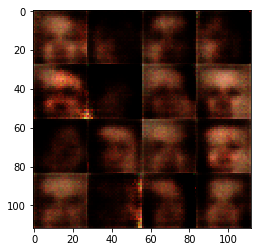

Epoch 1/1... Generator Loss: 1.6570 Discriminator Loss: 0.7457...
Epoch 1/1... Generator Loss: 0.9416 Discriminator Loss: 0.9895...
Epoch 1/1... Generator Loss: 1.0602 Discriminator Loss: 1.0842...
Epoch 1/1... Generator Loss: 1.4918 Discriminator Loss: 0.8157...
Epoch 1/1... Generator Loss: 0.6247 Discriminator Loss: 1.3971...
Epoch 1/1... Generator Loss: 0.5297 Discriminator Loss: 1.4255...
Epoch 1/1... Generator Loss: 0.8110 Discriminator Loss: 1.2264...
Epoch 1/1... Generator Loss: 0.6530 Discriminator Loss: 1.3140...
Epoch 1/1... Generator Loss: 0.7588 Discriminator Loss: 1.1777...
Epoch 1/1... Generator Loss: 0.7432 Discriminator Loss: 1.1178...


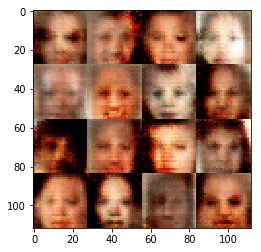

Epoch 1/1... Generator Loss: 1.2844 Discriminator Loss: 0.9646...
Epoch 1/1... Generator Loss: 2.8407 Discriminator Loss: 1.3872...
Epoch 1/1... Generator Loss: 2.6292 Discriminator Loss: 1.2456...
Epoch 1/1... Generator Loss: 1.5743 Discriminator Loss: 1.0129...
Epoch 1/1... Generator Loss: 1.3591 Discriminator Loss: 1.0577...
Epoch 1/1... Generator Loss: 1.3348 Discriminator Loss: 1.1321...
Epoch 1/1... Generator Loss: 0.6944 Discriminator Loss: 1.2022...
Epoch 1/1... Generator Loss: 1.7264 Discriminator Loss: 1.1360...
Epoch 1/1... Generator Loss: 1.2881 Discriminator Loss: 0.9703...
Epoch 1/1... Generator Loss: 0.9018 Discriminator Loss: 1.0443...


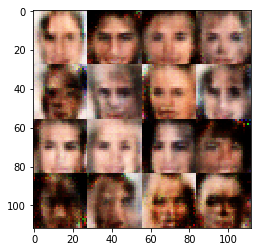

Epoch 1/1... Generator Loss: 1.4150 Discriminator Loss: 1.2191...
Epoch 1/1... Generator Loss: 1.6635 Discriminator Loss: 1.2996...
Epoch 1/1... Generator Loss: 2.2929 Discriminator Loss: 1.3909...
Epoch 1/1... Generator Loss: 1.5476 Discriminator Loss: 1.0769...
Epoch 1/1... Generator Loss: 3.0359 Discriminator Loss: 1.7467...
Epoch 1/1... Generator Loss: 0.4130 Discriminator Loss: 1.6695...
Epoch 1/1... Generator Loss: 2.2566 Discriminator Loss: 1.7349...
Epoch 1/1... Generator Loss: 0.1914 Discriminator Loss: 2.2021...
Epoch 1/1... Generator Loss: 1.2569 Discriminator Loss: 1.1077...
Epoch 1/1... Generator Loss: 1.2729 Discriminator Loss: 1.0984...


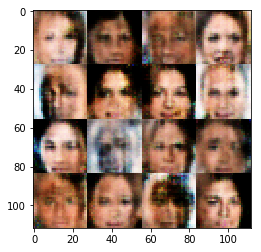

Epoch 1/1... Generator Loss: 0.4659 Discriminator Loss: 1.6815...
Epoch 1/1... Generator Loss: 0.2101 Discriminator Loss: 2.2273...
Epoch 1/1... Generator Loss: 1.4316 Discriminator Loss: 0.9883...
Epoch 1/1... Generator Loss: 1.0856 Discriminator Loss: 1.0686...
Epoch 1/1... Generator Loss: 2.1790 Discriminator Loss: 1.5789...
Epoch 1/1... Generator Loss: 1.1726 Discriminator Loss: 1.1289...
Epoch 1/1... Generator Loss: 1.2736 Discriminator Loss: 0.9524...
Epoch 1/1... Generator Loss: 1.1166 Discriminator Loss: 1.1300...
Epoch 1/1... Generator Loss: 0.5236 Discriminator Loss: 1.3821...
Epoch 1/1... Generator Loss: 1.8577 Discriminator Loss: 1.1555...


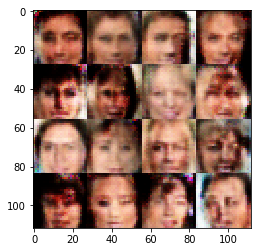

Epoch 1/1... Generator Loss: 0.9656 Discriminator Loss: 1.0411...
Epoch 1/1... Generator Loss: 1.4409 Discriminator Loss: 1.0615...
Epoch 1/1... Generator Loss: 0.7244 Discriminator Loss: 1.2059...
Epoch 1/1... Generator Loss: 1.7874 Discriminator Loss: 1.3104...
Epoch 1/1... Generator Loss: 0.4089 Discriminator Loss: 1.5964...
Epoch 1/1... Generator Loss: 0.8087 Discriminator Loss: 1.2662...
Epoch 1/1... Generator Loss: 1.3961 Discriminator Loss: 1.1881...
Epoch 1/1... Generator Loss: 0.6314 Discriminator Loss: 1.3861...
Epoch 1/1... Generator Loss: 0.8790 Discriminator Loss: 1.1107...
Epoch 1/1... Generator Loss: 1.2361 Discriminator Loss: 0.9685...


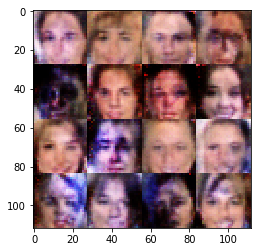

Epoch 1/1... Generator Loss: 1.2074 Discriminator Loss: 1.1214...
Epoch 1/1... Generator Loss: 0.8529 Discriminator Loss: 1.1045...
Epoch 1/1... Generator Loss: 1.4491 Discriminator Loss: 0.9909...
Epoch 1/1... Generator Loss: 1.6495 Discriminator Loss: 1.2879...
Epoch 1/1... Generator Loss: 1.0605 Discriminator Loss: 1.2765...
Epoch 1/1... Generator Loss: 0.4660 Discriminator Loss: 1.5327...
Epoch 1/1... Generator Loss: 1.5945 Discriminator Loss: 1.3272...
Epoch 1/1... Generator Loss: 0.6438 Discriminator Loss: 1.3225...
Epoch 1/1... Generator Loss: 0.9413 Discriminator Loss: 1.1221...
Epoch 1/1... Generator Loss: 1.1977 Discriminator Loss: 1.3078...


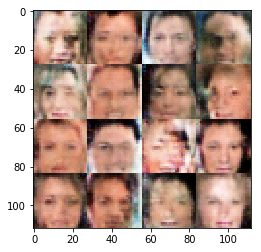

Epoch 1/1... Generator Loss: 1.1786 Discriminator Loss: 1.3550...
Epoch 1/1... Generator Loss: 0.7810 Discriminator Loss: 1.2914...
Epoch 1/1... Generator Loss: 0.9364 Discriminator Loss: 1.1684...
Epoch 1/1... Generator Loss: 1.2040 Discriminator Loss: 1.3169...
Epoch 1/1... Generator Loss: 0.4054 Discriminator Loss: 1.6151...
Epoch 1/1... Generator Loss: 1.1248 Discriminator Loss: 1.3465...
Epoch 1/1... Generator Loss: 0.4223 Discriminator Loss: 1.6659...
Epoch 1/1... Generator Loss: 0.8546 Discriminator Loss: 1.1627...
Epoch 1/1... Generator Loss: 0.6379 Discriminator Loss: 1.4308...
Epoch 1/1... Generator Loss: 1.0841 Discriminator Loss: 1.2031...


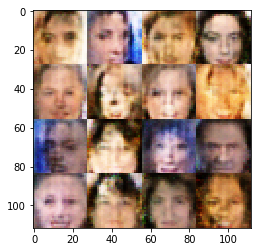

Epoch 1/1... Generator Loss: 0.7770 Discriminator Loss: 1.3271...
Epoch 1/1... Generator Loss: 0.6148 Discriminator Loss: 1.3642...
Epoch 1/1... Generator Loss: 1.1768 Discriminator Loss: 1.2573...
Epoch 1/1... Generator Loss: 0.8215 Discriminator Loss: 1.3491...
Epoch 1/1... Generator Loss: 0.7910 Discriminator Loss: 1.2939...
Epoch 1/1... Generator Loss: 0.8160 Discriminator Loss: 1.3152...
Epoch 1/1... Generator Loss: 1.0992 Discriminator Loss: 1.2265...
Epoch 1/1... Generator Loss: 0.7113 Discriminator Loss: 1.3428...
Epoch 1/1... Generator Loss: 0.8208 Discriminator Loss: 1.3978...
Epoch 1/1... Generator Loss: 0.9327 Discriminator Loss: 1.4270...


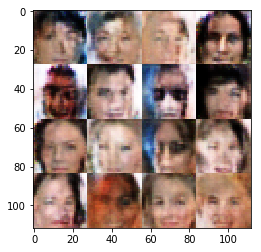

Epoch 1/1... Generator Loss: 0.8577 Discriminator Loss: 1.3566...
Epoch 1/1... Generator Loss: 0.8878 Discriminator Loss: 1.3155...
Epoch 1/1... Generator Loss: 0.9246 Discriminator Loss: 1.1742...
Epoch 1/1... Generator Loss: 0.7597 Discriminator Loss: 1.3866...
Epoch 1/1... Generator Loss: 1.1214 Discriminator Loss: 1.2912...
Epoch 1/1... Generator Loss: 0.9610 Discriminator Loss: 1.3586...
Epoch 1/1... Generator Loss: 0.8903 Discriminator Loss: 1.3650...
Epoch 1/1... Generator Loss: 0.9710 Discriminator Loss: 1.3017...
Epoch 1/1... Generator Loss: 0.7326 Discriminator Loss: 1.3639...
Epoch 1/1... Generator Loss: 0.5653 Discriminator Loss: 1.4403...


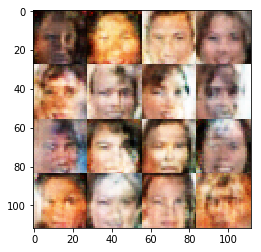

Epoch 1/1... Generator Loss: 0.8509 Discriminator Loss: 1.4211...
Epoch 1/1... Generator Loss: 0.7664 Discriminator Loss: 1.3907...
Epoch 1/1... Generator Loss: 0.7750 Discriminator Loss: 1.3426...
Epoch 1/1... Generator Loss: 0.5875 Discriminator Loss: 1.5133...
Epoch 1/1... Generator Loss: 0.9464 Discriminator Loss: 1.1390...
Epoch 1/1... Generator Loss: 0.8845 Discriminator Loss: 1.3399...
Epoch 1/1... Generator Loss: 0.5442 Discriminator Loss: 1.4241...
Epoch 1/1... Generator Loss: 0.7870 Discriminator Loss: 1.3906...
Epoch 1/1... Generator Loss: 0.9011 Discriminator Loss: 1.2164...
Epoch 1/1... Generator Loss: 0.7149 Discriminator Loss: 1.2352...


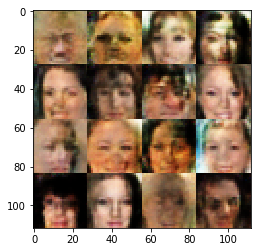

Epoch 1/1... Generator Loss: 0.7121 Discriminator Loss: 1.3742...
Epoch 1/1... Generator Loss: 1.2557 Discriminator Loss: 1.4144...
Epoch 1/1... Generator Loss: 0.7723 Discriminator Loss: 1.2534...
Epoch 1/1... Generator Loss: 0.6711 Discriminator Loss: 1.4328...
Epoch 1/1... Generator Loss: 0.7171 Discriminator Loss: 1.4168...
Epoch 1/1... Generator Loss: 0.7555 Discriminator Loss: 1.3874...
Epoch 1/1... Generator Loss: 0.6484 Discriminator Loss: 1.4292...
Epoch 1/1... Generator Loss: 0.9117 Discriminator Loss: 1.1984...
Epoch 1/1... Generator Loss: 1.1118 Discriminator Loss: 1.1899...
Epoch 1/1... Generator Loss: 0.5939 Discriminator Loss: 1.4054...


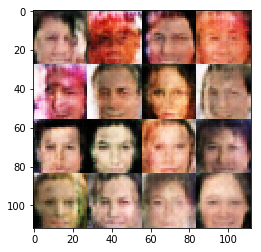

Epoch 1/1... Generator Loss: 0.7380 Discriminator Loss: 1.3475...
Epoch 1/1... Generator Loss: 0.9079 Discriminator Loss: 1.3663...
Epoch 1/1... Generator Loss: 0.9884 Discriminator Loss: 1.3071...
Epoch 1/1... Generator Loss: 0.7087 Discriminator Loss: 1.3773...
Epoch 1/1... Generator Loss: 0.6540 Discriminator Loss: 1.4677...
Epoch 1/1... Generator Loss: 0.8396 Discriminator Loss: 1.2891...
Epoch 1/1... Generator Loss: 1.0531 Discriminator Loss: 1.1839...
Epoch 1/1... Generator Loss: 0.8085 Discriminator Loss: 1.2715...
Epoch 1/1... Generator Loss: 0.7321 Discriminator Loss: 1.3320...
Epoch 1/1... Generator Loss: 0.7153 Discriminator Loss: 1.4056...


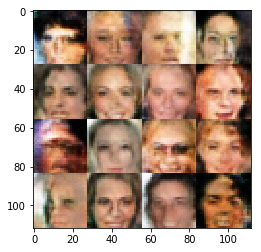

Epoch 1/1... Generator Loss: 0.8082 Discriminator Loss: 1.2727...
Epoch 1/1... Generator Loss: 0.7100 Discriminator Loss: 1.2631...
Epoch 1/1... Generator Loss: 0.8054 Discriminator Loss: 1.2559...
Epoch 1/1... Generator Loss: 0.7598 Discriminator Loss: 1.2943...
Epoch 1/1... Generator Loss: 0.6797 Discriminator Loss: 1.3161...
Epoch 1/1... Generator Loss: 0.6462 Discriminator Loss: 1.4042...
Epoch 1/1... Generator Loss: 0.9345 Discriminator Loss: 1.0669...
Epoch 1/1... Generator Loss: 0.6594 Discriminator Loss: 1.4013...
Epoch 1/1... Generator Loss: 0.8255 Discriminator Loss: 1.2551...
Epoch 1/1... Generator Loss: 0.8886 Discriminator Loss: 1.3664...


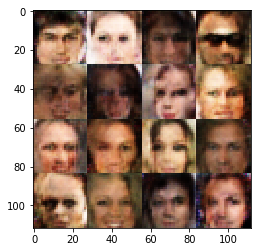

Epoch 1/1... Generator Loss: 0.9344 Discriminator Loss: 1.2711...
Epoch 1/1... Generator Loss: 0.8484 Discriminator Loss: 1.3439...
Epoch 1/1... Generator Loss: 0.7846 Discriminator Loss: 1.3860...
Epoch 1/1... Generator Loss: 1.0069 Discriminator Loss: 1.3236...
Epoch 1/1... Generator Loss: 0.7401 Discriminator Loss: 1.3628...
Epoch 1/1... Generator Loss: 0.7896 Discriminator Loss: 1.2540...
Epoch 1/1... Generator Loss: 0.8400 Discriminator Loss: 1.4108...
Epoch 1/1... Generator Loss: 0.9582 Discriminator Loss: 1.1686...
Epoch 1/1... Generator Loss: 0.8274 Discriminator Loss: 1.3181...
Epoch 1/1... Generator Loss: 0.7505 Discriminator Loss: 1.3389...


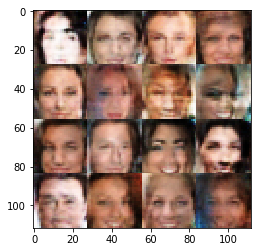

Epoch 1/1... Generator Loss: 0.9276 Discriminator Loss: 1.2502...
Epoch 1/1... Generator Loss: 0.8902 Discriminator Loss: 1.3450...
Epoch 1/1... Generator Loss: 0.8620 Discriminator Loss: 1.2506...
Epoch 1/1... Generator Loss: 0.5673 Discriminator Loss: 1.4716...
Epoch 1/1... Generator Loss: 0.7531 Discriminator Loss: 1.3290...
Epoch 1/1... Generator Loss: 0.6752 Discriminator Loss: 1.3783...
Epoch 1/1... Generator Loss: 0.7902 Discriminator Loss: 1.3849...
Epoch 1/1... Generator Loss: 0.6809 Discriminator Loss: 1.3412...
Epoch 1/1... Generator Loss: 0.7590 Discriminator Loss: 1.3108...
Epoch 1/1... Generator Loss: 0.8858 Discriminator Loss: 1.3079...


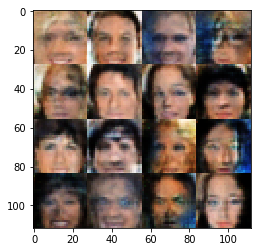

Epoch 1/1... Generator Loss: 0.8835 Discriminator Loss: 1.2946...
Epoch 1/1... Generator Loss: 0.9574 Discriminator Loss: 1.1711...
Epoch 1/1... Generator Loss: 1.0791 Discriminator Loss: 1.3504...
Epoch 1/1... Generator Loss: 0.7423 Discriminator Loss: 1.3622...
Epoch 1/1... Generator Loss: 0.7468 Discriminator Loss: 1.2787...
Epoch 1/1... Generator Loss: 1.0188 Discriminator Loss: 1.2317...
Epoch 1/1... Generator Loss: 0.6572 Discriminator Loss: 1.4086...
Epoch 1/1... Generator Loss: 0.8976 Discriminator Loss: 1.1342...
Epoch 1/1... Generator Loss: 0.8046 Discriminator Loss: 1.3820...
Epoch 1/1... Generator Loss: 0.6074 Discriminator Loss: 1.3957...


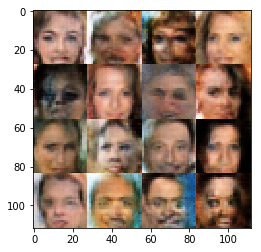

Epoch 1/1... Generator Loss: 0.8764 Discriminator Loss: 1.2630...
Epoch 1/1... Generator Loss: 0.8823 Discriminator Loss: 1.4034...
Epoch 1/1... Generator Loss: 0.9107 Discriminator Loss: 1.1365...
Epoch 1/1... Generator Loss: 0.6887 Discriminator Loss: 1.3201...
Epoch 1/1... Generator Loss: 0.7124 Discriminator Loss: 1.2974...
Epoch 1/1... Generator Loss: 0.9638 Discriminator Loss: 1.2978...
Epoch 1/1... Generator Loss: 0.8285 Discriminator Loss: 1.2607...
Epoch 1/1... Generator Loss: 0.8579 Discriminator Loss: 1.2052...
Epoch 1/1... Generator Loss: 0.9429 Discriminator Loss: 1.2029...
Epoch 1/1... Generator Loss: 0.6756 Discriminator Loss: 1.3160...


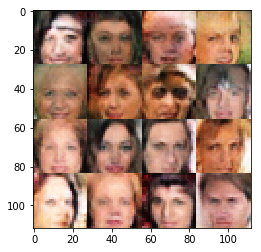

Epoch 1/1... Generator Loss: 0.6752 Discriminator Loss: 1.4107...
Epoch 1/1... Generator Loss: 0.8391 Discriminator Loss: 1.2387...
Epoch 1/1... Generator Loss: 1.0607 Discriminator Loss: 1.2046...
Epoch 1/1... Generator Loss: 0.8704 Discriminator Loss: 1.3388...
Epoch 1/1... Generator Loss: 1.0239 Discriminator Loss: 1.2799...
Epoch 1/1... Generator Loss: 0.7974 Discriminator Loss: 1.3637...
Epoch 1/1... Generator Loss: 0.9191 Discriminator Loss: 1.1881...
Epoch 1/1... Generator Loss: 0.7578 Discriminator Loss: 1.3692...
Epoch 1/1... Generator Loss: 0.6130 Discriminator Loss: 1.4025...
Epoch 1/1... Generator Loss: 0.7893 Discriminator Loss: 1.2721...


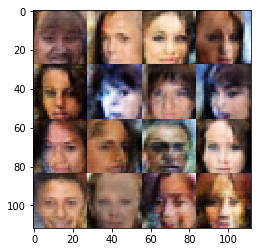

Epoch 1/1... Generator Loss: 0.9619 Discriminator Loss: 1.1970...
Epoch 1/1... Generator Loss: 0.7802 Discriminator Loss: 1.3530...
Epoch 1/1... Generator Loss: 0.6881 Discriminator Loss: 1.2390...
Epoch 1/1... Generator Loss: 0.8113 Discriminator Loss: 1.2701...
Epoch 1/1... Generator Loss: 0.8802 Discriminator Loss: 1.2079...
Epoch 1/1... Generator Loss: 0.9154 Discriminator Loss: 1.2915...
Epoch 1/1... Generator Loss: 0.6374 Discriminator Loss: 1.3731...
Epoch 1/1... Generator Loss: 0.7679 Discriminator Loss: 1.3202...
Epoch 1/1... Generator Loss: 0.5325 Discriminator Loss: 1.3808...
Epoch 1/1... Generator Loss: 0.8344 Discriminator Loss: 1.2867...


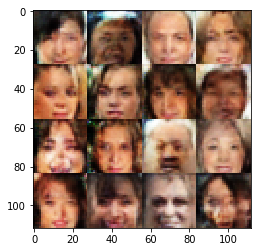

Epoch 1/1... Generator Loss: 0.6138 Discriminator Loss: 1.3764...
Epoch 1/1... Generator Loss: 0.9227 Discriminator Loss: 1.2734...
Epoch 1/1... Generator Loss: 0.8798 Discriminator Loss: 1.3089...
Epoch 1/1... Generator Loss: 0.6612 Discriminator Loss: 1.3716...
Epoch 1/1... Generator Loss: 0.6475 Discriminator Loss: 1.3853...
Epoch 1/1... Generator Loss: 1.1196 Discriminator Loss: 1.2697...
Epoch 1/1... Generator Loss: 0.9254 Discriminator Loss: 1.2115...
Epoch 1/1... Generator Loss: 0.7596 Discriminator Loss: 1.2887...
Epoch 1/1... Generator Loss: 0.9698 Discriminator Loss: 1.2548...
Epoch 1/1... Generator Loss: 0.7314 Discriminator Loss: 1.2994...


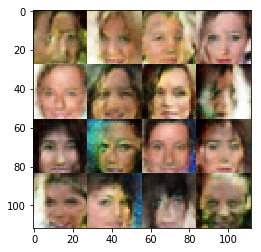

Epoch 1/1... Generator Loss: 0.7701 Discriminator Loss: 1.2764...
Epoch 1/1... Generator Loss: 0.9952 Discriminator Loss: 1.2983...
Epoch 1/1... Generator Loss: 0.8941 Discriminator Loss: 1.1968...
Epoch 1/1... Generator Loss: 0.6763 Discriminator Loss: 1.3003...
Epoch 1/1... Generator Loss: 0.7642 Discriminator Loss: 1.3152...
Epoch 1/1... Generator Loss: 0.8511 Discriminator Loss: 1.4352...
Epoch 1/1... Generator Loss: 0.8408 Discriminator Loss: 1.2771...
Epoch 1/1... Generator Loss: 0.9547 Discriminator Loss: 1.3464...
Epoch 1/1... Generator Loss: 0.8633 Discriminator Loss: 1.2761...
Epoch 1/1... Generator Loss: 0.8902 Discriminator Loss: 1.3171...


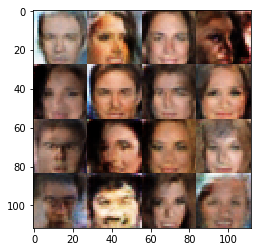

Epoch 1/1... Generator Loss: 0.6636 Discriminator Loss: 1.4786...
Epoch 1/1... Generator Loss: 0.7507 Discriminator Loss: 1.2761...
Epoch 1/1... Generator Loss: 0.6366 Discriminator Loss: 1.4842...
Epoch 1/1... Generator Loss: 0.8126 Discriminator Loss: 1.2008...
Epoch 1/1... Generator Loss: 0.8459 Discriminator Loss: 1.3643...
Epoch 1/1... Generator Loss: 0.8663 Discriminator Loss: 1.2563...
Epoch 1/1... Generator Loss: 1.0004 Discriminator Loss: 1.2089...
Epoch 1/1... Generator Loss: 0.8007 Discriminator Loss: 1.2872...
Epoch 1/1... Generator Loss: 0.6435 Discriminator Loss: 1.4835...
Epoch 1/1... Generator Loss: 0.9232 Discriminator Loss: 1.2005...


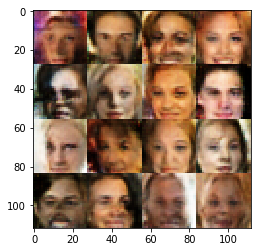

Epoch 1/1... Generator Loss: 0.8008 Discriminator Loss: 1.3344...
Epoch 1/1... Generator Loss: 0.9022 Discriminator Loss: 1.2396...
Epoch 1/1... Generator Loss: 0.8447 Discriminator Loss: 1.3785...
Epoch 1/1... Generator Loss: 0.7819 Discriminator Loss: 1.3630...
Epoch 1/1... Generator Loss: 0.7537 Discriminator Loss: 1.3527...
Epoch 1/1... Generator Loss: 0.7385 Discriminator Loss: 1.2906...
Epoch 1/1... Generator Loss: 0.7478 Discriminator Loss: 1.2870...
Epoch 1/1... Generator Loss: 0.9609 Discriminator Loss: 1.2565...
Epoch 1/1... Generator Loss: 0.9038 Discriminator Loss: 1.3285...
Epoch 1/1... Generator Loss: 0.7924 Discriminator Loss: 1.2855...


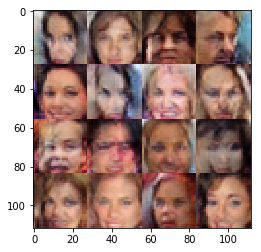

Epoch 1/1... Generator Loss: 0.7873 Discriminator Loss: 1.2809...
Epoch 1/1... Generator Loss: 0.8084 Discriminator Loss: 1.1772...
Epoch 1/1... Generator Loss: 0.8866 Discriminator Loss: 1.3436...
Epoch 1/1... Generator Loss: 0.9269 Discriminator Loss: 1.2800...
Epoch 1/1... Generator Loss: 0.8334 Discriminator Loss: 1.2309...
Epoch 1/1... Generator Loss: 0.7203 Discriminator Loss: 1.2882...
Epoch 1/1... Generator Loss: 0.9099 Discriminator Loss: 1.2489...
Epoch 1/1... Generator Loss: 0.7011 Discriminator Loss: 1.3417...
Epoch 1/1... Generator Loss: 0.7375 Discriminator Loss: 1.3100...
Epoch 1/1... Generator Loss: 0.5464 Discriminator Loss: 1.5024...


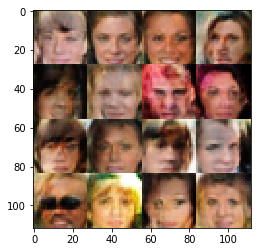

Epoch 1/1... Generator Loss: 0.8186 Discriminator Loss: 1.4052...
Epoch 1/1... Generator Loss: 0.7050 Discriminator Loss: 1.2833...
Epoch 1/1... Generator Loss: 0.7859 Discriminator Loss: 1.3088...
Epoch 1/1... Generator Loss: 0.9276 Discriminator Loss: 1.2694...
Epoch 1/1... Generator Loss: 0.6960 Discriminator Loss: 1.4020...
Epoch 1/1... Generator Loss: 0.6122 Discriminator Loss: 1.3895...
Epoch 1/1... Generator Loss: 0.7341 Discriminator Loss: 1.3854...
Epoch 1/1... Generator Loss: 0.9792 Discriminator Loss: 1.2040...
Epoch 1/1... Generator Loss: 0.9983 Discriminator Loss: 1.1843...
Epoch 1/1... Generator Loss: 0.8082 Discriminator Loss: 1.4061...


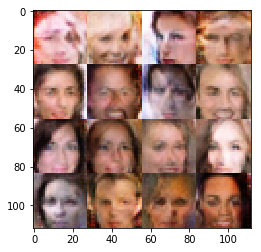

Epoch 1/1... Generator Loss: 0.7477 Discriminator Loss: 1.2515...
Epoch 1/1... Generator Loss: 0.8473 Discriminator Loss: 1.2651...
Epoch 1/1... Generator Loss: 0.7943 Discriminator Loss: 1.3063...
Epoch 1/1... Generator Loss: 0.7260 Discriminator Loss: 1.3489...
Epoch 1/1... Generator Loss: 0.7472 Discriminator Loss: 1.3108...
Epoch 1/1... Generator Loss: 0.8912 Discriminator Loss: 1.2965...
Epoch 1/1... Generator Loss: 0.5661 Discriminator Loss: 1.4374...
Epoch 1/1... Generator Loss: 0.7800 Discriminator Loss: 1.3768...
Epoch 1/1... Generator Loss: 0.6490 Discriminator Loss: 1.3652...
Epoch 1/1... Generator Loss: 0.7424 Discriminator Loss: 1.3262...


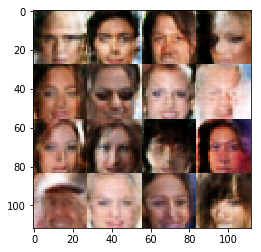

Epoch 1/1... Generator Loss: 0.7643 Discriminator Loss: 1.3352...
Epoch 1/1... Generator Loss: 0.7174 Discriminator Loss: 1.4257...
Epoch 1/1... Generator Loss: 0.8912 Discriminator Loss: 1.3082...
Epoch 1/1... Generator Loss: 0.7063 Discriminator Loss: 1.4425...
Epoch 1/1... Generator Loss: 0.6304 Discriminator Loss: 1.5146...
Epoch 1/1... Generator Loss: 0.7775 Discriminator Loss: 1.3005...
Epoch 1/1... Generator Loss: 0.7187 Discriminator Loss: 1.2763...
Epoch 1/1... Generator Loss: 0.6820 Discriminator Loss: 1.2741...
Epoch 1/1... Generator Loss: 0.7868 Discriminator Loss: 1.3598...
Epoch 1/1... Generator Loss: 0.6279 Discriminator Loss: 1.4523...


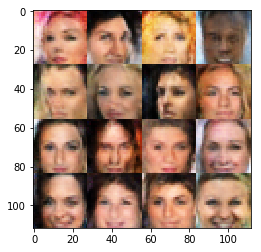

Epoch 1/1... Generator Loss: 0.7214 Discriminator Loss: 1.3531...
Epoch 1/1... Generator Loss: 0.7322 Discriminator Loss: 1.3295...
Epoch 1/1... Generator Loss: 0.7490 Discriminator Loss: 1.3100...
Epoch 1/1... Generator Loss: 0.6304 Discriminator Loss: 1.4297...
Epoch 1/1... Generator Loss: 0.8951 Discriminator Loss: 1.2436...
Epoch 1/1... Generator Loss: 0.6526 Discriminator Loss: 1.3771...
Epoch 1/1... Generator Loss: 0.7613 Discriminator Loss: 1.2563...
Epoch 1/1... Generator Loss: 0.6510 Discriminator Loss: 1.4665...
Epoch 1/1... Generator Loss: 0.6072 Discriminator Loss: 1.3975...
Epoch 1/1... Generator Loss: 0.7623 Discriminator Loss: 1.3399...


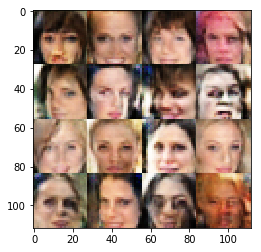

Epoch 1/1... Generator Loss: 0.7236 Discriminator Loss: 1.2977...
Epoch 1/1... Generator Loss: 0.6785 Discriminator Loss: 1.3657...
Epoch 1/1... Generator Loss: 0.7033 Discriminator Loss: 1.2800...
Epoch 1/1... Generator Loss: 0.7771 Discriminator Loss: 1.3660...
Epoch 1/1... Generator Loss: 0.8238 Discriminator Loss: 1.3937...
Epoch 1/1... Generator Loss: 0.7388 Discriminator Loss: 1.4692...
Epoch 1/1... Generator Loss: 0.6076 Discriminator Loss: 1.3839...
Epoch 1/1... Generator Loss: 0.8653 Discriminator Loss: 1.2600...
Epoch 1/1... Generator Loss: 0.8100 Discriminator Loss: 1.2538...
Epoch 1/1... Generator Loss: 0.8669 Discriminator Loss: 1.3298...


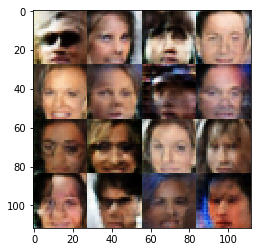

Epoch 1/1... Generator Loss: 0.7922 Discriminator Loss: 1.3800...
Epoch 1/1... Generator Loss: 0.8831 Discriminator Loss: 1.3101...
Epoch 1/1... Generator Loss: 0.6646 Discriminator Loss: 1.4869...
Epoch 1/1... Generator Loss: 0.6801 Discriminator Loss: 1.4094...
Epoch 1/1... Generator Loss: 0.8371 Discriminator Loss: 1.3011...
Epoch 1/1... Generator Loss: 0.6845 Discriminator Loss: 1.2842...


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。